This notebook is part of the *orix* documentation https://orix.rtfd.io. Links to the documentation won’t work from the notebook.

# Clustering misorientations

This notebook illustrates clustering of Ti crystal misorientations using data
obtained from a highly deformed specimen, using EBSD, as presented in
<cite data-cite="johnstone2020density">Johnstone et al. (2020)</cite>. The data
is available here:
https://drive.google.com/drive/folders/1jJBWlOD3Q7klpEU3PvtSrp7Lmcn5o1af.

Import orix classes and various dependencies

In [1]:
# exchange inline for notebook (or qt5 from pyqt) for interactive plotting
%matplotlib inline

# Important core external
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Colorisation and visualisation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb
from matplotlib.lines import Line2D

# Import orix classes
from orix import plot
from orix.quaternion import Orientation, OrientationRegion, Misorientation, Rotation
from orix.quaternion.symmetry import D6
from orix.vector import AxAngle, Vector3d


plt.rcParams.update({
    "font.size": 20, "figure.figsize": (10, 10), "figure.facecolor": "w"
})

## Import data

Load orientation mapping data specified in a standard CTF file as euler angles in degrees, following the Bunge convention

In [2]:
filepath = "/home/hakon/kode/orix_test/Ti_orientations.ctf"
euler = np.loadtxt(filepath, skiprows=1, usecols=(0, 1, 2))

Create an orientation instance from the Euler angles, defined in
the MTEX convention as transformations from the crystal to the
sample reference frame. Set the point group symmetry *D6* (*622*)
of Ti.

In [3]:
ori = Orientation.from_euler(np.deg2rad(euler), direction="crystal2lab", symmetry=D6)

Reshape the orientation mapping data to the correct spatial dimension for the
scan

In [4]:
ori = ori.reshape(381, 507)

Select a subset of the orientations to a suitable size for this demonstration

In [5]:
ori = ori[-100:, :200]

Map the orientations into the fundamental zone (find
symmetrically equivalent orientations with the smallest
angle of rotation) of *D6*

In [6]:
ori = ori.map_into_symmetry_reduced_zone()

Compute misorientations

In [7]:
mori_all = Misorientation(~ori[:, :-1] * ori[:, 1:])

Keep only misorientations assumed to be on boundaries, i.e. with a
disorientation angle higher than 7$^{\circ}$

In [8]:
boundary_mask = mori_all.angle > np.deg2rad(7)
mori = mori_all[boundary_mask]

Map the misorientations into the fundamental zone of (*D6*, *D6*)

In [9]:
mori.symmetry = (D6, D6)
mori = mori.map_into_symmetry_reduced_zone()

## Compute distance matrix

Clustering algorithms require a distance matrix, $D_{ij}$, containing the distance, $d(o_i, o_j)$,
between all (mis)orientations to be computed. We define this distance as the minimum rotational angle relating 
(mis)orientations amongst all symmetry equivalent rotations.

Computation of the distance matrix is the most computationally intensive part of this data processing. Here we 
provide 3 alternative implementations that use resources differently:

1. Calculate the outer products needed to determine the distance metric and compute the associated angle. Minimise with respect to the tensor axes corresponding to symmetry. Uses lots of of computer memory.

2. Iterating over pairs of data points while performing an outer product minimisation with respect to the symmetry elements for each pair. Uses more computer memory to avoid excessive computation times.


**WARNING: The computation in Section 2.1 takes time and may exceed limits on your machine. This section is 
commented out to avoid unintentional use. A pre-computed solution is provided in Section 2.2!**# <a id='dis'></a> 

### Compute the distance matrix yourself (optional)

**Option 1: high (ca. 32 Gb) RAM, fast vectorized computation**

Computes every possibility in a single tensor, then minimises.

In [10]:
#mismisori = (~mori2).outer(mori2)
#mismisori_equiv = D6.outer(~mori2).outer(D6).outer(D6).outer(mori2).outer(D6)
#D = mismisori_equiv.angle.data.min(axis=(0, 2, 3, 5))

**Option 3: RAM vs. speed compromise**

Precomputes one set of equivalent orientations.

In [11]:
#from itertools import combinations_with_replacement as icombinations
#from tqdm import tqdm_notebook
#D = np.empty((misori.size, misori.size))
#
#for i, j in tqdm_notebook(list(icombinations(range(mori2.size), 2))):
#    m1, m2 = mori2[i], mori2[j]
#    mismisori = D6.outer(~m1).outer(D6).outer(D6).outer(m2).outer(D6)
#    d = mismisori.angle.data.min(axis=(0, 2, 3, 5))
#    D[i, j] = d
#    D[j, i] = d

### Load a distance matrix we computed for you

In [12]:
filepath_2 = "/home/hakon/kode/orix_test/misori-distance((100, 200)).npy"
D = np.load(filepath_2)

## Clustering

Apply mask to remove small misorientations associated with grain orientation spread

In [13]:
small_mask = mori.angle < np.deg2rad(7)
D = D[~small_mask][:, ~small_mask]
mori = mori[~small_mask]

For parameter explanations of the DBSCAN algorithm (Density-Based Spatial
Clustering for Applications with Noise), see the
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [14]:
# Compute clusters
dbscan = DBSCAN(
    eps=0.05,
    min_samples=10,
    metric="precomputed"
).fit(D)

unique_labels, all_cluster_sizes = np.unique(dbscan.labels_, return_counts=True)
print("Labels:", unique_labels)

n_clusters = unique_labels.size - 1
print("Number of clusters:", n_clusters)

Labels: [-1  0  1  2  3]
Number of clusters: 4


Calculate the mean misorientation associated with each cluster

In [15]:
unique_cluster_labels = unique_labels[1:]  # Without the "no-cluster" label -1
cluster_sizes = all_cluster_sizes[1:]

rc = Rotation.from_axes_angles((0, 0, 1), np.deg2rad(15))

mori_mean = []
for label in unique_cluster_labels:
    # Rotate
    mori_i = rc * mori[dbscan.labels_ == label]

    # Map into the fundamental zone
    mori_i.symmetry = (D6, D6)
    mori_i = mori_i.map_into_symmetry_reduced_zone()

    # Get the cluster mean
    mori_i = mori_i.mean()

    # Rotate back and add to list
    cluster_mean_local = (~rc) * mori_i
    mori_mean.append(cluster_mean_local)

cluster_means = Misorientation.stack(mori_mean).flatten()

# Map into the fundamental zone
cluster_means.symmetry = (D6, D6)
cluster_means = cluster_means.map_into_symmetry_reduced_zone()
cluster_means

Misorientation (4,) 622, 622
[[ 0.8467  0.2664  0.4606  0.0037]
 [-0.7858 -0.3094 -0.5355 -0.0044]
 [-0.9515 -0.3075 -0.0015 -0.007 ]
 [ 0.8656  0.4338  0.2501  0.0055]]

Inspect misorientations in the axis-angle representation

In [16]:
cluster_means.axis

Vector3d (4,)
[[0.5006 0.8656 0.007 ]
 [0.5003 0.8658 0.0072]
 [0.9997 0.0048 0.0228]
 [0.8663 0.4994 0.0109]]

In [17]:
np.rad2deg(cluster_means.angle)

array([64.29349881, 76.40971082, 35.82903611, 60.10115054])

Define reference misorientations associated with twinning orientation relationships

In [18]:
# From Krakow et al.
twin_theory = Rotation.from_axes_angles(
    axes=[
        (1, 0, 0),  # sigma7a
        (1, 0, 0),  # sigma11a
        (2, 1, 0),  # sigma11b
        (1, 0, 0),  # sigma13a
        (2, 1, 0),  # sigma13b
    ],
    angles=np.deg2rad([64.40, 34.96, 85.03, 76.89, 57.22])
)

Calculate difference, defined as minimum rotation angle, between measured and
theoretical values

In [19]:
mori2 = (~twin_theory).outer(cluster_means)
mori2_equiv = D6.outer(~twin_theory).outer(D6).outer(D6).outer(cluster_means).outer(D6)
D2 = mori2_equiv.angle.min(axis=(0, 2, 3, 5))

In [20]:
np.rad2deg(D2)

array([[ 0.44196598, 12.01907556, 28.59166542, 31.00602591],
       [29.33528603, 41.45127188,  1.18969475, 34.15185331],
       [37.89471722, 35.23189781, 54.83306878, 25.25351347],
       [12.60503699,  0.70196626, 41.07796156, 37.24075935],
       [27.53333357, 34.58980591, 29.35942936,  4.44471339]])

We see that the first, second, third, and fourth clusters are within $4.5^{\circ}$
of $\Sigma7$a, $\Sigma13$a, $\Sigma11$a, and $\Sigma13$b, respectively.

## Visualisation

Associate colours with clusters for plotting

In [21]:
colors = [to_rgb(f"C{i}") for i in range(cluster_means.size)]
labels_rgb = label2rgb(dbscan.labels_, colors=colors, bg_label=-1)

Inspect misorientation axes of clusters in an inverse pole figure

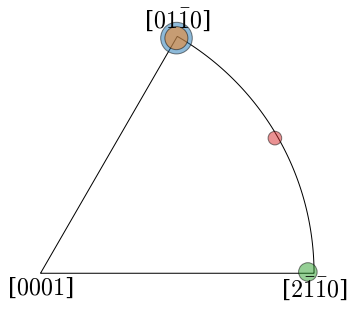

In [22]:
cluster_sizes = all_cluster_sizes[1:]
cluster_sizes_scaled = 1000 * cluster_sizes / cluster_sizes.max()

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="ipf", symmetry=D6))
ax.scatter(
    cluster_means.axis, c=colors, s=cluster_sizes_scaled, alpha=0.5, ec="k"
)

Plot a top view of the misorientation clusters within the fundamental zone for
the (*D6*, *D6*) bicrystal symmetry

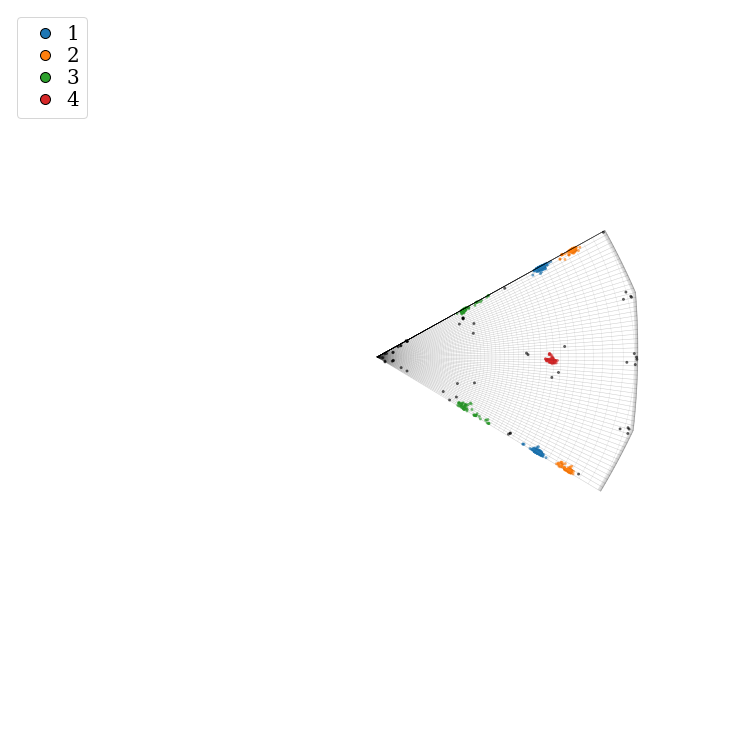

In [28]:
wireframe_kwargs = dict(color="black", linewidth=0.5, alpha=0.1, rcount=361, ccount=361)
fig = mori.scatter(
    projection="axangle",
    wireframe_kwargs=wireframe_kwargs,
    c=labels_rgb.reshape(-1, 3),
    s=4,
    alpha=0.5,
    return_figure=True,
)
ax = fig.axes[0]
ax.view_init(elev=90, azim=-60)

handle_kwds = dict(marker="o", color="none", markersize=10)
handles = []
for i in range(n_clusters):
    line = Line2D([0], [0], label=i + 1, markerfacecolor=colors[i], **handle_kwds)
    handles.append(line)
ax.legend(
    handles=handles,
    loc="upper left",
    numpoints=1,
    labelspacing=0.15,
    columnspacing=0.15,
    handletextpad=0.05
);

Plot side view of misorientation clusters in the fundamental zone for the (*D6*, *D6*) bicrystal symmetry

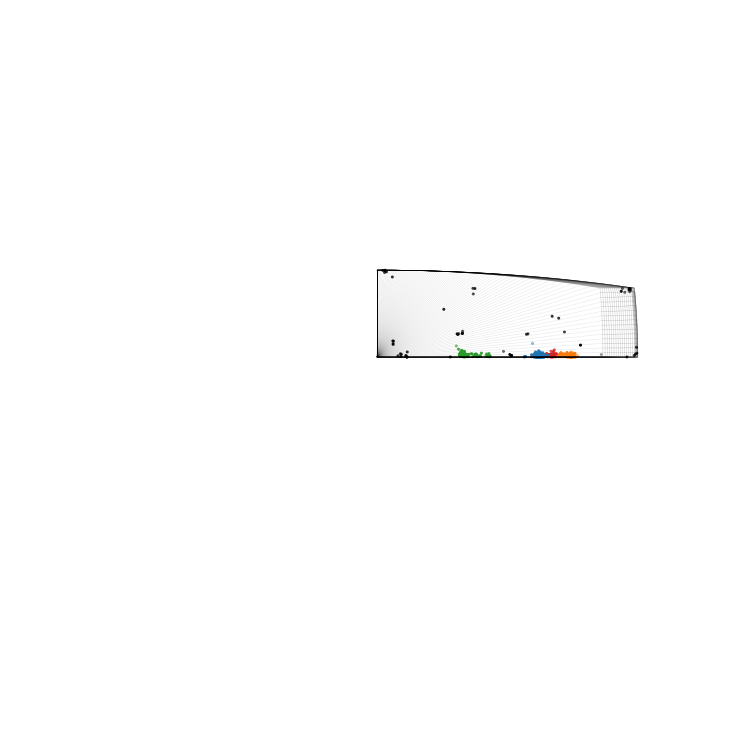

In [24]:
fig2 = mori.scatter(
    return_figure=True,
    wireframe_kwargs=wireframe_kwargs,
    c=labels_rgb.reshape(-1, 3),
    s=4,
)
ax2 = fig2.axes[0]
ax2.view_init(elev=0, azim=-60)

Generate map of boundaries colored according to cluster membership

In [25]:
mapping = np.ones(mori_all.shape + (3,))
new_mask = np.where(boundary_mask)[0][~small_mask], np.where(boundary_mask)[1][~small_mask]
mapping[new_mask] = labels_rgb

Plot map of boundaries colored according to cluster membership

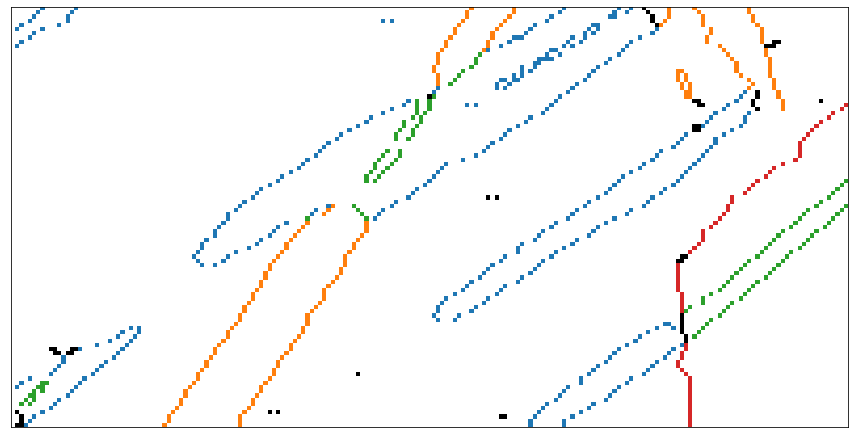

In [26]:
fig3, ax3 = plt.subplots(figsize=(15, 10))
ax3.imshow(mapping)
ax3.set_xticks([])
ax3.set_yticks([]);